# Compressed Sensing Project 
## Aymeric Floyrac and Benoit Ané, 3A ENSAE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

In [2]:
import cv2

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 1. Data Visualization
We present here our medical images and extracted points from the following website : https://anhir.grand-challenge.org/?fbclid=IwAR0BcDFh6vpsdJJey6ajgMfAKyH0SPA3YqZcbrsz8zguu9orF70_Rl2umK4 .
We are going to align these points clouds in the next sections.

In [5]:
path = 'dataset-CIMA_scale-5pc/lung-lesion_1/scale-5pc/'
#path = ''

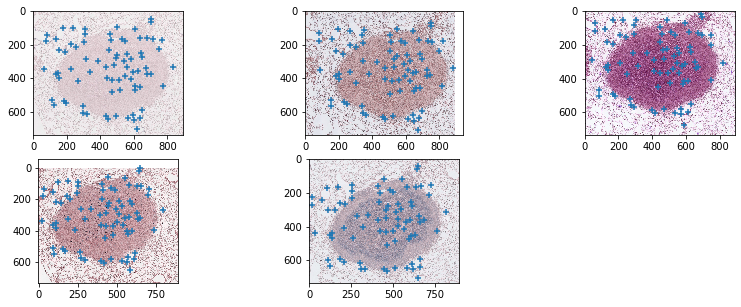

In [6]:
fig = plt.figure(figsize=(14,5))
for i in range(1,6):
    img = cv2.imread(path+'img'+str(i)+'.jpg')
    df = pd.read_csv(path+'img'+str(i)+'.csv')
    ax = fig.add_subplot(2,3,i)
    ax.imshow(img)
    ax.scatter(df['X'],df['Y'],marker='+')

In [7]:
data = []
for i in range(1,6):
    df = pd.read_csv(path +'img'+str(i)+'.csv')
    data.append(df[['X','Y']].values)

## 2. Iterative closest point (ICP)
We use the following github code as source for our implementation : https://github.com/ClayFlannigan/icp

In [21]:
from sklearn.neighbors import NearestNeighbors

In [8]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m-1,:] *= -1
        R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

def align_two_sets(set0,ref):
    """
    Input: 
        set0: the set of points to align
        ref: the reference set of points
    Output: 
        transfo: the aligned set of points
    """
    T,dist, it = icp(set0,ref)
    R = T[:2,:2].T
    translation = T[:2,2]
    scale = T[2,2]
    transfo = np.matmul(scale * set0,R) + translation
    return transfo

def compute_error(transfo,ref):
    """computes the RMSE between the reference set and the aligned set"""
    rmse = np.sqrt(mean_squared_error(ref,transfo))
    return rmse

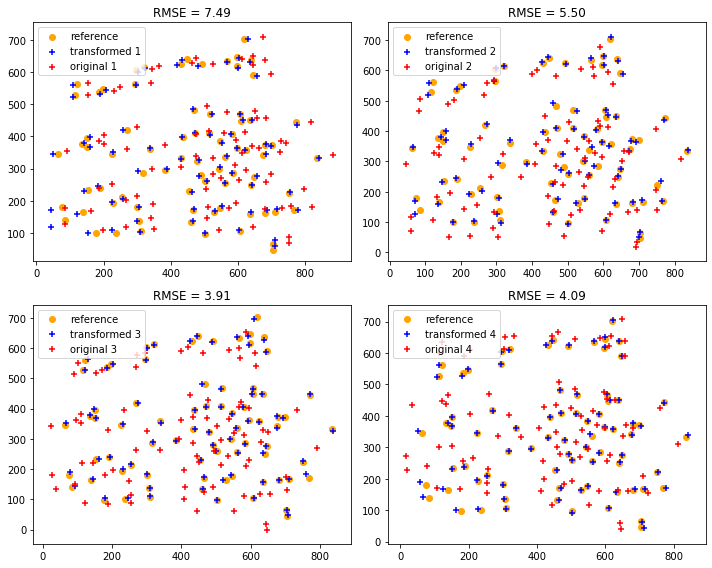

In [10]:
#Here we plot the results of our implementation with image1 and its points as reference
# and we apply ICP method to all other points cloud
ref = data[0]
fig = plt.figure(figsize=(10,8))
for i in range(1,5):
    ax = fig.add_subplot(2,2,i)
    transfo = align_two_sets(data[i],ref)
    rmse = compute_error(transfo,ref)
    ax.scatter(ref[:,0],ref[:,1],marker='o',color='orange',label='reference')
    ax.scatter(transfo[:,0],transfo[:,1],marker='+',color='b',label='transformed '+str(i))
    ax.scatter(data[i][:,0],data[i][:,1],marker = '+', color = 'r', label='original '+str(i))
    ax.legend()
    ax.set_title(f'RMSE = {rmse:.2f}')
plt.tight_layout()
plt.show()

We can say that the ICP is an efficient method due to its speed and small RMSE for all points clouds.

## 3. Coherent point drift (CPD)
We use the following GitHub repository for our implementation: https://github.com/siavashk/pycpd

In [10]:
from functools import partial
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import time

In [35]:
class RigidRegistration(object):
    """Implementation of CPD algorithm for rigid registration"""
    def __init__(self, X, Y, R=None, t=None, s=None, sigma2=None, maxIterations=100, tolerance=0.001, w=0):
        """Builder of class
        Input:
            X: reference points cloud
            Y: target points cloud"""
        if X.shape[1] != Y.shape[1]:
            raise 'Both point clouds must have the same number of dimensions!'
        self.X             = X
        self.Y             = Y
        self.input1        = str(X)
        self.input2        = str(Y)
        (self.N, self.D)   = self.X.shape
        (self.M, _)        = self.Y.shape
        self.R             = np.eye(self.D) if R is None else R
        self.t             = np.atleast_2d(np.zeros((1, self.D))) if t is None else t
        self.s             = 1 if s is None else s
        self.sigma2        = sigma2
        self.iteration     = 0
        self.maxIterations = maxIterations
        self.tolerance     = tolerance
        self.w             = w
        self.q             = 0
        self.err           = 0

    def register(self, callback):
        """Function to initalize the algorithm and ton run interation until stop conditions:
        max iteration number or tolerance threshold"""
        self.initialize()
        while self.iteration < self.maxIterations and self.err > self.tolerance:
            self.iterate()
        return self.Y, self.s, self.R, self.t

    def iterate(self):
        """Function to iterate over E-step, M-step"""
        self.EStep()
        self.MStep()
        self.iteration = self.iteration + 1

    def MStep(self):
        """Once correspondences probabilities are known, 
        we maximize the negative log-likelihood that 
        the observed points were sampled from 
        the GMM with respect to transformation parameters """
        self.updateTransform()
        self.transformPointCloud()
        self.updateVariance()

    def updateTransform(self):
        """Once correspondence probabilities are known, i.e. P, 
        we can solve for the transformation parameters.
        In the case of rigid registration, 
        these transform parameters are the rotation matrix and the translation vector"""
        muX = np.divide(np.sum(np.dot(self.P, self.X), axis=0), self.Np)
        muY = np.divide(np.sum(np.dot(np.transpose(self.P), self.Y), axis=0), self.Np)

        self.XX = self.X - np.tile(muX, (self.N, 1))
        YY      = self.Y - np.tile(muY, (self.M, 1))
        self.A = np.dot(np.transpose(self.XX), np.transpose(self.P))
        self.A = np.dot(self.A, YY)
        U, _, V = np.linalg.svd(self.A, full_matrices=True)
        C = np.ones((self.D, ))
        C[self.D-1] = np.linalg.det(np.dot(U, V))

        self.R = np.dot(np.dot(U, np.diag(C)), V)

        self.YPY = np.dot(np.transpose(self.P1), np.sum(np.multiply(YY, YY), axis=1))

        self.s = np.trace(np.dot(np.transpose(self.A), self.R)) / self.YPY

        self.t = np.transpose(muX) - self.s * np.dot(self.R, np.transpose(muY))

    def transformPointCloud(self, Y=None):
        """Find the new points cloud at a specific iteration step with new parameters"""
        if not Y:
            self.Y = self.s * np.dot(self.Y, np.transpose(self.R)) + np.tile(np.transpose(self.t), (self.M, 1))
            return
        else:
            return self.s * np.dot(Y, np.transpose(self.R)) + np.tile(np.transpose(self.t), (self.M, 1))

    def updateVariance(self):
        """Update sigma2 of gaussian distribution for next iteration"""
        qprev = self.q
        trAR     = np.trace(np.dot(self.A, np.transpose(self.R)))
        xPx      = np.dot(np.transpose(self.Pt1), np.sum(np.multiply(self.XX, self.XX), axis =1))
        self.q   = (xPx - 2 * self.s * trAR + self.s * self.s * self.YPY) / (2 * self.sigma2) + self.D * self.Np/2 * np.log(self.sigma2)
        self.err = np.abs(self.q - qprev)
        self.sigma2 = (xPx - self.s * trAR) / (self.Np * self.D)
        if self.sigma2 <= 0:
            self.sigma2 = self.tolerance / 10

    def initialize(self):
        """Function to initialize variance of Gaussian distribution thanks to points clouds"""
        self.Y = self.s * np.dot(self.Y, np.transpose(self.R)) + np.repeat(self.t, self.M, axis=0)
        if not self.sigma2:
            XX = np.reshape(self.X.values, (1, self.N, self.D))
            YY = np.reshape(self.Y, (self.M, 1, self.D))
            XX = np.tile(XX, (self.M, 1, 1))
            YY = np.tile(YY, (1, self.N, 1))
            diff = XX - YY
            err  = np.multiply(diff, diff)
            self.sigma2 = np.sum(err) / (self.D * self.M * self.N)
        self.err  = self.tolerance + 1
        self.q    = -self.err - self.N * self.D/2 * np.log(self.sigma2)

    def EStep(self):
        """Function to find which Gaussian the observed point cloud was sampled from"""
        P = np.zeros((self.M, self.N))
        for i in range(0, self.M):
            diff     = self.X - np.tile(self.Y[i, :], (self.N, 1))
            diff    = np.multiply(diff, diff)
            P[i, :] = P[i, :] + np.sum(diff, axis=1)
        c = (2 * np.pi * self.sigma2) ** (self.D / 2)
        c = c * self.w / (1 - self.w)
        c = c * self.M / self.N
        P = np.exp(-P / (2 * self.sigma2))
        """However, since we are dealing with multiple Gaussians, 
        we need to normalize this probability by the contribution of all Gaussian centroids."""
        den = np.sum(P, axis=0)
        den = np.tile(den, (self.M, 1))
        den[den==0] = np.finfo(float).eps
        self.P   = np.divide(P, den)
        self.Pt1 = np.sum(self.P, axis=0)
        self.P1  = np.sum(self.P, axis=1)
        self.Np = np.sum(self.P1)

def visualize(X, Y,name1,name2):
    """"Function to visualize the aligned points
    Input:
        X: reference points cloud
        Y: transformed points cloud
        name1: str, label 1
        name2: str, label 2
    Output: 
        plot"""
    plt.cla()
    rmse = compute_error(Y[:,1],X.values[:,1])
    plt.scatter(X.values[:,0] ,  X.values[:,1], color='orange',label = name1)
    plt.scatter(Y[:,0] ,  Y[:,1], color='blue', label = name2)
    plt.title("RMSE = "+str(rmse))
    
def main(input1,input2):
    """"Function to run CPD algorithm
    Input:
        input1: csv, reference points cloud
        input2: csv, target points cloud
    Output:
        X: reference points cloud
        Y: transformed points cloud
        s: scale
        R: rotation
        t: translation
        Y0: target points """
    X = pd.read_csv(input1)
    X = X.iloc[:,1:]
    Y0 = pd.read_csv(input2)
    Y0 = Y0.iloc[:,1:]
    callback = partial(visualize)
    reg = RigidRegistration(X, Y0)
    Y, s, R, t = reg.register(callback)
    return X, Y, s, R, t, Y0 

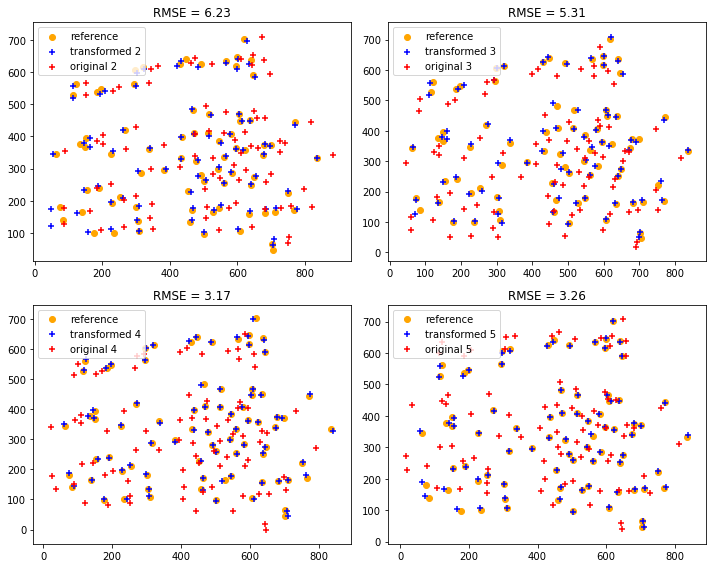

In [24]:
#Here we plot the results of our implementation with image1 and its points as reference
# and we apply CPD method to all other points cloud
fig = plt.figure(figsize=(10,8))
liste_csv = ['img2.csv','img3.csv','img4.csv','img5.csv']
for i,image in zip(range(2,6),liste_csv):
    ax = fig.add_subplot(2,2,i-1)
    X, Y, s, R, t, Y0 = main('img1.csv',image)
    rmse = compute_error(Y[:,1],X.values[:,1])
    ax.scatter(X.values[:,0] ,  X.values[:,1], color='orange',label = 'reference')
    ax.scatter(Y[:,0] ,  Y[:,1],marker='+',color='b',label='transformed '+str(i))
    ax.scatter(Y0.values[:,0] ,  Y0.values[:,1],marker='+',color='r',label='original '+str(i))
    ax.legend()
    ax.set_title(f'RMSE = {rmse:.2f}')
plt.tight_layout()
plt.show()

The CPD method seems to be as good as the ICP method in terms of speed and RMSE. But its implementation was a bit harder.

## 3. Unsupervised alignment (Grave's method)
We use the following github code as source for our implementation : https://github.com/facebookresearch/fastText/blob/master/alignment/unsup_align.py

In [13]:
import codecs, sys, time, math, argparse, ot

In [10]:
def procrustes(X_src, Y_tgt):
    U, s, V = np.linalg.svd(np.dot(Y_tgt.T, X_src))
    return np.dot(U, V)

def objective(X, Y, R, n=78):
    Xn, Yn = X[:n], Y[:n]
    C = -np.dot(np.dot(Xn, R), Yn.T)
    C /= max(C.max(),-C.min())
    P = ot.sinkhorn(np.ones(n), np.ones(n), C, 0.025, stopThr=1e-3)
    return np.linalg.norm(np.dot(Xn, R) - np.dot(P, Yn)) / n

def retrieve_permutation(X,Y,R,n=78):
    """
    Find the permutation from X,Y and the R matrix that has been estimated
    """
    Xn, Yn = X[:n], Y[:n]
    C = -np.dot(np.dot(Xn, R), Yn.T)
    C /= max(C.max(),-C.min()) #rescale to avoid overflow => it does not change the solution
    P = ot.sinkhorn(np.ones(n), np.ones(n), C, 0.025, stopThr=1e-3)
    maxP = np.argmax(P,axis=1)
    P = (P == P.max(axis=1, keepdims=True)).astype(int) #convert P to binary matrix
    return P



def align(X, Y, R, lr=10., bsz=200, nepoch=5, niter=1000,nmax=10000, reg=0.05, verbose=False):
    """
    the main algorithm "stochastic optimization"
    """
    for epoch in range(1, nepoch + 1):
        for _it in range(1, niter + 1):
            # sample mini-batch
            xt = X[np.random.permutation(nmax)[:bsz], :]
            yt = Y[np.random.permutation(nmax)[:bsz], :]
            # compute OT on minibatch
            C = -np.dot(np.dot(xt, R), yt.T)
            C /= max([C.max(),-C.min()]) #rescale the cost to avoid overflow 
            P = ot.sinkhorn(np.ones(bsz), np.ones(bsz), C, reg, stopThr=1e-3)
            # compute gradient
            G = - np.dot(xt.T, np.dot(P, yt))
            R -= lr / bsz * G
            # project on orthogonal matrices
            U, s, VT = np.linalg.svd(R)
            R = np.dot(U, VT)
            #print(R)
        bsz *= 2
        niter //= 4
        if verbose:
            print("epoch: %d  obj: %.3f" % (epoch, objective(X, Y, R,n=78)))
    P = retrieve_permutation(X,Y,R,len(X))
    return R,P


def convex_init(X, Y, niter=100, reg=0.05):
    """
    Find a good initialization point for align, using a convex relaxation
    """
    n, d = X.shape
    K_X, K_Y = np.dot(X, X.T).astype(float), np.dot(Y, Y.T).astype(float)
    K_Y *= np.linalg.norm(K_X) / np.linalg.norm(K_Y)
    K2_X, K2_Y = np.dot(K_X, K_X), np.dot(K_Y, K_Y)
    #Frank-Wolfe algorithm
    P = np.ones([n, n]) / float(n)
    for it in range(1, niter + 1):
        G = np.dot(P, K2_X) + np.dot(K2_Y, P) - 2 * np.dot(K_Y, np.dot(P, K_X))
        G/=max([G.max(),-G.min()]) #rescaling to avoid overflow => does not change the problem solution
        s = ot.sinkhorn(np.ones(n), np.ones(n), G, reg, stopThr=1e-3)
        alpha = 2.0 / float(2.0 + it)
        P = alpha * s + (1.0 - alpha) * P
    obj = np.linalg.norm(np.dot(P, K_X) - np.dot(K_Y, P))
    Q0 = procrustes(np.dot(P, X), Y).T
    return Q0


To prevent the solutions from exploding in ```align```, we need to use a strong regularization ```reg=1```.
The batch size, the learning rate, the number of iterations and the number of epochs have been tuned.

We assume in the following code that P is the identity matrix, which is true in our case (for simplicity). However, in a general case, we would have used P to reorder the row elements of ```data[i]``` before applying the transformation and computing the error. 

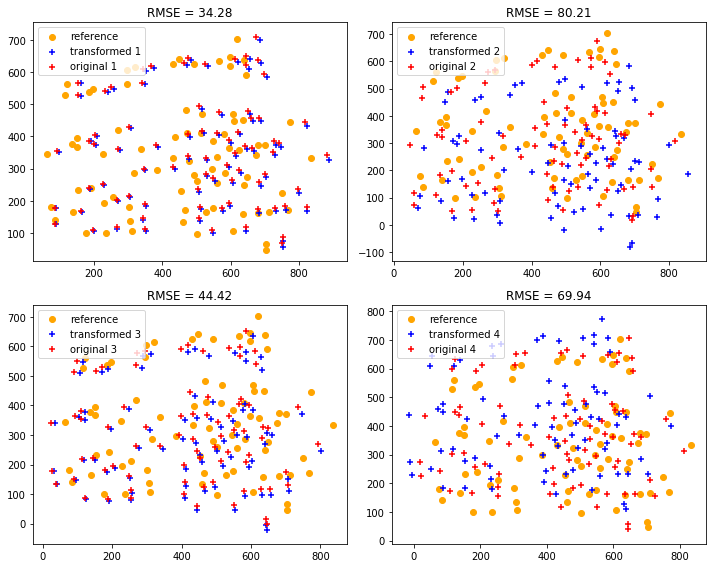

In [14]:
#Here we plot the results of our implementation with image1 and its points as reference
# and we apply Grave's method to all other points cloud
ref = data[0]
fig = plt.figure(figsize=(10,8))
for i in range(1,5):
    ax = fig.add_subplot(2,2,i)
    Q0 = convex_init(data[0],data[i])
    R,P = align(data[0], data[i], Q0.copy(), bsz=10, lr=0.001, niter=30,nepoch=5, reg=1, nmax=78)
    transfo = np.dot(data[i],R) #assuming P is the identity
    rmse = compute_error(transfo,ref)
    ax.scatter(ref[:,0],ref[:,1],marker='o',color='orange',label='reference')
    ax.scatter(transfo[:,0],transfo[:,1],marker='+',color='b',label='transformed '+str(i))
    ax.scatter(data[i][:,0],data[i][:,1],marker = '+', color = 'r', label='original '+str(i))
    ax.legend()
    ax.set_title(f'RMSE = {rmse:.2f}')

plt.tight_layout()
plt.show()

We can say that the RMSE is worse than the other methods. Grave's method takes more time to run for this dataset and is not performing as well as expected. Moreover, the implementation of this algorithm was by far the most difficult, with several arrangements to be made (scaling of the cost matrices, strong regularization).

## 4. Speed comparison between ICP and Grave's method
We are going here to test the speed of both algorithms for a bigger points cloud. We will simulate a cloud with 1000 points (we tried with 10000 but our computer did not resist Grave's method at this scale).

In [16]:
import random
import timeit

In [17]:
random.seed(27)
np.random.seed(27)

In [18]:
X_sim = np.random.uniform(0, 70000, size = 1000)
Y_sim = np.random.uniform(0, 80000, size = 1000)
ref_sim = np.hstack([X_sim[:, np.newaxis], Y_sim[:, np.newaxis]])

In [19]:
X_t_sim = X_sim + 2*np.random.randn(len(X_sim))
Y_t_sim = Y_sim + 2*np.random.randn(len(Y_sim))
target_sim = np.hstack([X_t_sim[:, np.newaxis], Y_t_sim[:, np.newaxis]])

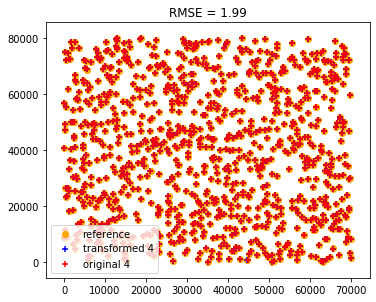

CPU times: user 484 ms, sys: 15 ms, total: 499 ms
Wall time: 515 ms


In [22]:
%%time
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,2,1)
transfo = align_two_sets(target_sim,ref_sim)
rmse = compute_error(transfo,ref_sim)
ax.scatter(ref_sim[:,0],ref_sim[:,1],marker='o',color='orange',label='reference')
ax.scatter(transfo[:,0],transfo[:,1],marker='+',color='b',label='transformed '+str(i))
ax.scatter(target_sim[:,0],target_sim[:,1],marker = '+', color = 'r', label='original '+str(i))
ax.legend()
ax.set_title(f'RMSE = {rmse:.2f}')
plt.tight_layout()
plt.show()

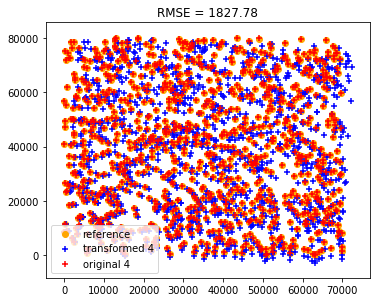

CPU times: user 42 s, sys: 1.08 s, total: 43.1 s
Wall time: 23 s


In [24]:
%%time
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,2,1)
Q0 = convex_init(ref_sim,target_sim)
R,P = align(ref_sim, target_sim, Q0.copy(), bsz=10, lr=0.001, niter=30,nepoch=5, reg=1, nmax=78)
transfo = np.dot(target_sim,R) 
rmse = compute_error(transfo,ref_sim)
ax.scatter(ref_sim[:,0],ref_sim[:,1],marker='o',color='orange',label='reference')
ax.scatter(transfo[:,0],transfo[:,1],marker='+',color='b',label='transformed '+str(i))
ax.scatter(target_sim[:,0],target_sim[:,1],marker = '+', color = 'r', label='original '+str(i))
ax.legend()
ax.set_title(f'RMSE = {rmse:.2f}')
plt.tight_layout()
plt.show()

We can conclude that the ICP seems to be the more efficient method in order to align points cloud because it is faster and has a lower RMSE than Grave's method for a large dataset. As a conclusion, there seem to be no advantage to using Grave's method in this context of medical imaging.